## Searching for an accessing content
With our connection to AGOL via the ArcGIS Python API we have access to all its shared content! But to access it, we need a means to locate it and get it into our coding environment. This notebook explores the following: 
* Searching for AGOL content and handling the search results
 * In ArcGIS online (review)
 * Using the ArcGIS Python API
* Fetching specific AGOL resources by their resource ID

#### Resources
* Guide: https://developers.arcgis.com/python/guide/accessing-and-creating-content/

#### Example: Searching for Census Data
To give context for this lesson, suppose we want to use come census tract data in our code. One route for getting the data we want is to look for it online. Here, we navigate to https://arcgis.com and search for `Census Tracts`. When I checked last, that search returned > 30,000 records! So we'd need to refine our search. If we knew the owner of the dataset, we could add `owner:` to our search. We can also filter by **item type** and even filter for **authoritative** datasets.  

---
###   Part 1: Searching for content via AGOL (*review*): 
_First we'll search for objects in ArcGIS Online and familiarize ourselves with various attributes with our results._
1. Search [ArcGIS Online](https://arcgis.com) for <u>`Census Tracts Areas`</u> owned by <u>`esri_dm`</u>, filtering results for <u>feature layers</u> only.
 * The final search term should be: `census tract areas owner:esri_dm type:feature`


2. Open the [link](https://www.arcgis.com/home/item.html?id=db3f9c8728dd44e4ad455e0c27a85eea) to the one result.
 * Note the URL for the link, particularly the *id* returned: `db3f9c8728dd44e4ad455e0c27a85eea`
 
 
3. Scroll to the bottom of the page. On the right side, find the [URL](https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Census_Tract_Areas_analysis_trim/FeatureServer) associated with the feature layer and open it in your browser. 
 * Note this page also reveals the item's ID. 
 * This page shows that the feature layer service serves just the one layer: `tracts_trim`.
 
 
4. Open the [link](https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/USA_Census_Tract_Areas_analysis_trim/FeatureServer/0) to the `tracts_trim` feature layer's *REST endpoint*.
 * What attributes are associated with this layer? 
 * How many records can be retrieved at one time from this service? 


5. At the bottom of the page, find the link associated with the [Query](https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/USA_Census_Tract_Areas_analysis_trim/FeatureServer/0/query) interface for this layer.


6. In the query interface enter `FIPS LIKE '37063%'` as the *Where clause*. Then scroll to the bottom and click the `Query(GET)` button. 
 * How many records are returned? 
 * Modify the query to return output format as `GeoJSON` and click `Query(GET)` again. 
 
_What we just did was use AGOL to find a layer, access its REST endpoint, and use the REST api to query Census tracts for Durham County, setting the output to be a GeoJSON object. We can copy these results into a text file and convert the GeoJSON to a feature class using ArcGIS Pro's [JSON To Features](https://pro.arcgis.com/en/pro-app/tool-reference/conversion/json-to-features.htm) tool or through Python pakages like Fiona or Geopandas (more on that later...)_

---

### Part 2: Working with content via the ArcGIS Python API
The ArcGIS Python APIs [GIS module](https://developers.arcgis.com/python/guide/the-gis-module/) allows us to execute the same process above, but from within our coding environment instead of our web browser. Here we explore how that's done, using the opportunity to better understand the structure and working of this powerful API.  

#### Step 1. Importing the API's GIS module
To access the API, we need to import it. We aren't accessing any 'premium' content here, so we can authenticate "anonymously":

In [1]:
#Import the GIS object and authenticate using your ArcGIS Pro credentials
from arcgis import GIS
gis = GIS('home')

#### Step 2. Use the GIS module's [Content Manager](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#contentmanager) to search AGOL
Instead of clicking on web links in our browser, we'll use one of the helper objects access via the GIS module, namely the [Content Manager](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#contentmanager), to execute our search. This is done by passing our search terms and our item type filters to the `gis.content.search()` command. ([link to help](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.search))

The code below searches for all "Census Tracts" items and reveals how many items are returned. Here we cap it at 1000 items. We could easily increase the cap, but you get the idea. The `outside_org=True` is not really necessary here as we are using an anonymous login to the GIS object. However, if we signed into, say, our dukeuniv.maps.arcgis.com account when authenticating the GIS object, we'd need the `outside_org = True` statement to extend our search to content not created by fellow Dukies. 

In [3]:
#Use the API's content' helper to search for feature layers with keyword Census and owner is "esri_dm"
results = gis.content.search(query='Census Tracts Areas')
#Show the list of results returned
results

[<Item title:"USA_Census_Tract_Areas_with_Inspection_Count" type:Feature Layer Collection owner:mgs57_dukeuniv>,
 <Item title:"USA Population Density 2020-Copy" type:Web Map owner:nlj14_dukeuniv>,
 <Item title:"At-Risk Population in Houston" type:Web Mapping Application owner:nwh11_dukeuniv>,
 <Item title:"DevelopedLandinARA_HiNFIPClaims" type:Map Image Layer owner:kjd15_dukeuniv>,
 <Item title:"USA Population Density 2020-Copy-Copy" type:Web Map owner:nlj14_dukeuniv>,
 <Item title:"WakeMedianIncome" type:Feature Layer Collection owner:anb29_dukeuniv>,
 <Item title:"Aggregation_of_Multifamily_Properties___Assisted_to_census2016acs_by_Block_Group" type:Feature Layer Collection owner:sjc75_dukeuniv>]

_Just two results?? What happened??_

We have to modify our search to (1) explore records outside of Duke and (2) return more than the default of 10 records.
* Run the code first with the `max_items` option commented, then with it uncommented. 

In [6]:
#Use the API's content' helper to search for feature layers with keyword Census and owner is "esri_dm"
results = gis.content.search(query='Census Tracts Areas',
                             outside_org=True
                             ,max_items=1000
                            )
                            
#Show the number of results returned
len(results)

1000

Now we'll amend the query to limit our results just to Census Tract *feature layers* that are *owned by "esri_dm"*. 
* Alter the code cell below filling in the same query string we used before for the `query=` option.
* Next, specify the item_type to be a `Feature Layer`. 

In [9]:
#Use the API's content' helper to search for feature layers with keyword Census and owner is "esri_dm"
results = gis.content.search(query='Census Tracts Areas owner:esri_dm',
                             item_type='Feature Layer',
                             outside_org=True)
#Show the complete list of results returned
results

[<Item title:"USA Census Tract Areas" type:Feature Layer Collection owner:esri_dm>]

Just the one item returned - same as when we searched via the Web! Phew...

``` ► More info and examples on searching:``` https://developers.arcgis.com/python/guide/accessing-and-creating-content/

---
 

### Step 3. Exploring the item(s) returned.
Just as we did with our browser-based searched results, we'll drill into the item obtained through our search.
* First, we'll extract the one item as its own variable - `tractsItem` - and then examine that object various ways...

In [10]:
#Extract the one returned item in the list to the "tractsItem" variable
tractsItem = results[0]

In [11]:
#Reveal the Python data type of this object
type(tractsItem)

arcgis.gis.Item

In [12]:
#Reveal the arcgis type of this object: A feature service
tractsItem.type

'Feature Service'

<Item title:"USA Census Tract Areas" type:Feature Layer Collection owner:esri_dm>
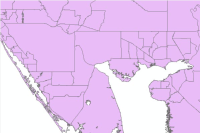

In [13]:
#We can display the formatted AGOL info on that item:
tractsItem

In [14]:
#Show help documentation on the "arcgis.gis.Item" object
tractsItem?

Or, more detailed documentation on ArcGIS Item object is here:<br>
→ https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item

* Open this link and view the functions associated with the object. 
 * What does the `content_status` function reveal? 
 * The `id` function? 
 * The `download` function??
_Note that not all these functions will work on this item. Some of them are for modifying the actual feature layer hosted on AGOL, which we don't have privileges to do._ 


* Next, reveal the `id` associated with the item -- and compare that to the one you found by seaching AGOL in your browser? 

In [15]:
#Reveal the id associated with this item
tractsItem.id

'db3f9c8728dd44e4ad455e0c27a85eea'

We'll dig deeper into how to work with these items in a subsequent workbook. For now, let's return to how to fetch data into our coding environment, but with more direct methods.

---
###  Fetching an AGOL dataset by its item ID
When we searched for our census data via ArcGIS Online in a web browser, we noted the unique ID contained in [the item's resource page](https://www.arcgis.com/home/item.html?id=db3f9c8728dd44e4ad455e0c27a85eea): `db3f9c8728dd44e4ad455e0c27a85eea`. 

You may have also noticed that the item's ID is listed in the item's [ESRI REST endpoint page](https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Census_Tract_Areas_analysis_trim/FeatureServer).

And lastly, we can extract that number after we've accessed via ArcGIS Python search methods shown above. 

These item IDs are useful to know because **we can use that to access the item directly**, i.e., without having to search for it. 

<Item title:"USA Census Tract Areas" type:Feature Layer Collection owner:esri_dm>
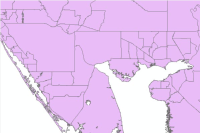

In [16]:
#Extract the Census tracts layer directly, via its ID
other_tractsItem = gis.content.get('db3f9c8728dd44e4ad455e0c27a85eea')
other_tractsItem

## Summary
Accessing content begins specifying the resource that you want to access. You can do this a number of ways: 
* Searching for the resource in ArcGIS Online and recording its item ID
* Searching for the resource using the ArcGIS Python API
* Directly from its feature ID, if known